## GBM для передбачення академічної успішності.

У цьому завданні ви працюватимете з даними про успішність учнів португальської школи (джерело: UCI Machine Learning Repository). Для кожного учня задані такі атрибути, як освіта батьків, розмір сім’ї, показники відвідування, деталі особистого життя та багато інших.
Ви використаєте популярні бібліотеки pandas, scikit-learn та XGBoost, щоб побудувати ансамбль із регресійних дерев і передбачити оцінку учня на фінальному іспиті з математики. Також, ви визначите, які ознаки модель вважає найважливішими для передбачення.

#### Імпортування необхідних бібліотек 

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from collections import Counter
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import train_test_split

/Users/Vera/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Заватнаження данних

In [2]:
students = pd.read_csv('student-mat.csv', sep=';')
students.style

#### Застосуємо one-hot encoding для категоріальних змінних

In [3]:
students_train = pd.get_dummies(students, columns=['school', 'sex', 'address','famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian'])

#### Закодуємо бінарні ознаки як 1/0

In [4]:
le = preprocessing.LabelEncoder()
def to_binary_columns(columns):
    for column in columns:
        le.fit(students_train[column])
        students_train[column] = le.transform(students_train[column])
        
binary_columns = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
to_binary_columns(binary_columns)

#### Вилучимо колонки G1, G2, G3. Колонку G3 будемо передбачати

In [5]:
del students_train['G1']
del students_train['G2']
del students_train['G3']

In [6]:
students_train.style

#### Розділимо дані в пропорції 90%:10% для навчання та тестування

In [7]:
train_X,test_X = train_test_split(students_train, test_size=0.1, random_state=42)
train_y,test_y = train_test_split(students['G3'], test_size=0.1, random_state=42)

#### Hатренуємо XGBRegressor на 200 дерев із максимальною глибиною 4, learning rate 0.05

In [8]:
gbm = xgb.XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=200, seed=42).fit(train_X, train_y)

#### Використовуючи тестову вибірку, обчислимо середню похибку передбачення (MAE).

In [9]:
mae = mean_absolute_error(test_y, gbm.predict(test_X))
print('Cередня похибка передбачення (MAE):', mae)

Cередня похибка передбачення (MAE): 3.25385516882


#### Побудуємо residual plot (графік різниці між передбаченими та істинними значеннями) TODO

#### Використовуючи натреновану модель, отримаємо чисельну важливість кожної ознаки та побудуємо гістограму

In [10]:
feature_importance = gbm.booster().get_fscore()

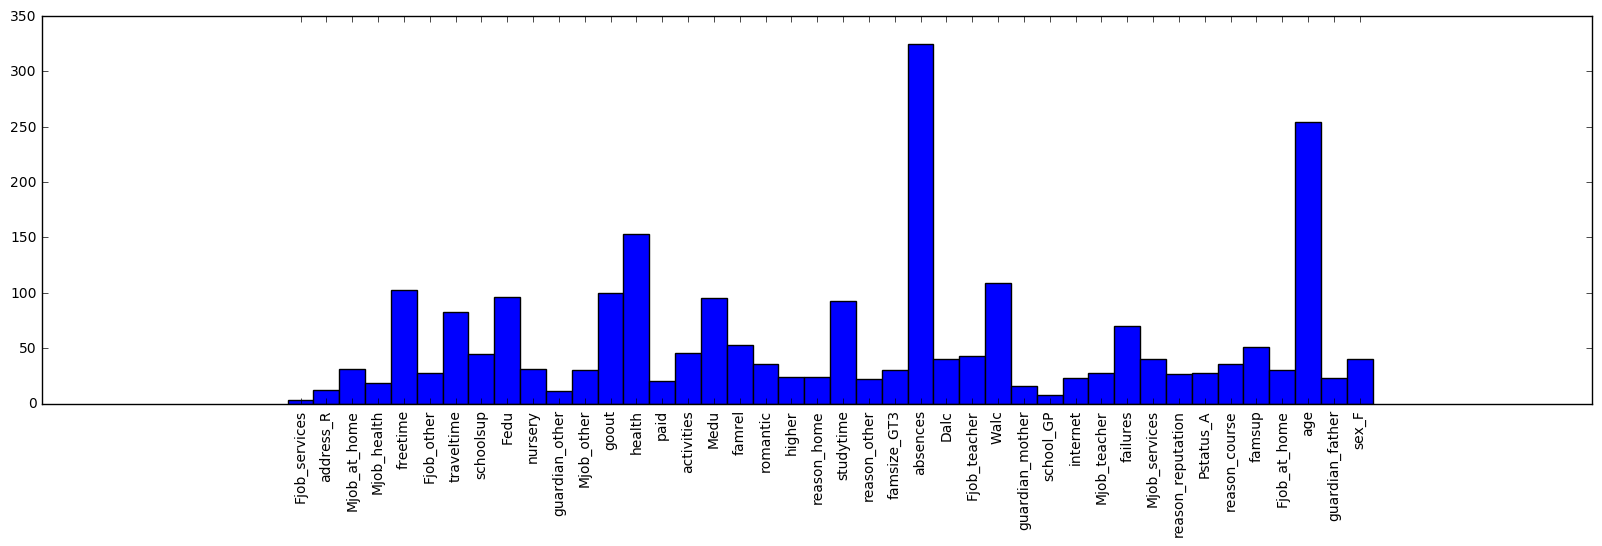

In [11]:
X = np.arange(len(feature_importance))
plt.figure(figsize=(20,5))
plt.bar(X, feature_importance.values(), align='center', width=1)
plt.xticks(X, feature_importance.keys(), rotation=90)
plt.show()

#### Знайдемо 5 найважливіших ознак

In [12]:
Counter(feature_importance).most_common(5)

[('absences', 325),
 ('age', 254),
 ('health', 153),
 ('Walc', 109),
 ('freetime', 103)]

#### Змінимо кількість дерев у моделі в діапазоні від 10 до 300 та порахуємо MAE на тестовій вибірці.

In [35]:
def train_models(trees, maes):
    for tree in trees:
        model = xgb.XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=tree, seed=42).fit(train_X, train_y)
        mae = mean_absolute_error(test_y, model.predict(test_X))
        maes.append(mae)
        print('кількість дерев:', tree, '| середня похибка передбачення:', mae)
        print('----------------------------------------------------------')

In [36]:
trees = np.arange(10, 301, 5)
maes = []
train_models(trees, maes)

кількість дерев: 10 | середня похибка передбачення: 6.60093344152
----------------------------------------------------------
кількість дерев: 15 | середня похибка передбачення: 5.50010842681
----------------------------------------------------------
кількість дерев: 20 | середня похибка передбачення: 4.78385347128
----------------------------------------------------------
кількість дерев: 25 | середня похибка передбачення: 4.29256833792
----------------------------------------------------------
кількість дерев: 30 | середня похибка передбачення: 4.02395173907
----------------------------------------------------------
кількість дерев: 35 | середня похибка передбачення: 3.85046544671
----------------------------------------------------------
кількість дерев: 40 | середня похибка передбачення: 3.730924505
----------------------------------------------------------
кількість дерев: 45 | середня похибка передбачення: 3.60845790505
----------------------------------------------------------
кі

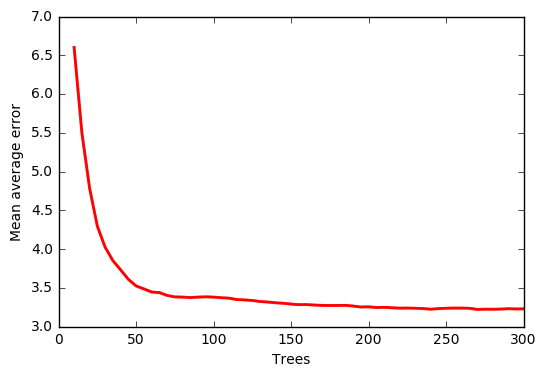

In [34]:
plt.plot(trees,maes, color="red", alpha=0.7, linewidth=2.0)
plt.ylabel('Mean average error')
plt.xlabel('Trees')
plt.show()